In [ ]:
import warnings
warnings.filterwarnings('ignore')
from importlib import reload
import utils
reload(utils)
import snake_ai
reload(snake_ai)
from snake_ai import SnakeEnv,DQNAgent,save_training_state,load_training_state
from utils import Struct,seed_everything,zip_files,get_rect_size

import matplotlib.pyplot as plt
plt.style.use("default") # 先恢复默认
plt.style.use("ggplot") # 再设置主题
plt.rcParams["font.sans-serif"]=["SimHei"] # 设置字体
plt.rcParams["axes.unicode_minus"]=False # 该语句解决图像中的“-”负号的乱码问题
plt.rcParams['font.size'] = 12  # 字体大小

import torch,random,os
from datetime import datetime
from time import time
import matplotlib.pyplot as plt
from copy import deepcopy
import numpy as np
import pandas as pd
from PyQt5.QtWidgets import QApplication

In [ ]:
# train
seed_everything(2025)
continue_flag=False # 是否要在之前的结果上继续训练
is_save_training_state=False # 是否保存训练状态
break_hours = 11.5 # 多久后终止
if continue_flag:
    args,info_map,random_state=load_training_state(load_path='checkpoints')
    if 'qt_app' not in globals():
        qt_app = QApplication([])

    args.window_title = 'Snake AI Train'
    env = SnakeEnv(args, qt_app=qt_app)  # 训练环境
    args.window_title = 'Snake AI Test'
    test_env = SnakeEnv(args, qt_app=qt_app) # 测试环境
    print('state_size',args.state_size)

    current_episode = info_map[1]['current_episode'] + 1
    episode_info = random_state['episode_info']

    random.setstate(random_state['python'])
    np.random.set_state(random_state['numpy'])
    torch.set_rng_state(random_state['torch'])
    if torch.cuda.is_available() and random_state['cuda'] is not None:
        torch.cuda.set_rng_state_all(random_state['cuda'])
else:
    args = {
        'is_training': 1,
        'window_title': 'Snake AI',
        'grid_width': 10,
        'grid_height': 10,
        'first_direction': 'none',
        'each_score_steps': 50,
        'is_env': True,

        # 模型超参数
        'hidden_size':[256,128,64],
        'dropout':0,
        'action_size': 3,
        'learning_rate': 1e-4,
        'buffer_size': 1000000,
        'gamma' : 0.99,           # 折扣因子
        'epsilon' : 1.0,          # 初始探索率
        'epsilon_min' : 0,        # 最小探索率
        'epsilon_decay' : 0.998,  # 探索率衰减
        'tau' : 1e-3,             # 目标网络软更新系数
        'batch_size' : 256,       # 训练批量大小
        'update_every' : 1,       # 网络更新频率
        'early_stop_num': 150,    # mean_max_score连续没提升多少次数后终止训练

        'beta_start': 0.4,        # 重要性采样初始值
        'beta_increment': 1e-5,   # beta的增量
        'per_alpha': 0.6,         # 优先级强度系数
        'decay_factor': 0.1,      # 采样次数衰减系数

        'visible_every': 50,
        'do_test_every': 100,
        'episodes': 10000,
        'device': torch.device("cuda" if torch.cuda.is_available() else "cpu"),
        'use_amp': False,
        'save_path': 'checkpoints'

    }
    args = Struct(**args)
    if 'qt_app' not in globals():
        qt_app = QApplication([])

    screen = QApplication.primaryScreen()
    args.dpi = screen.logicalDotsPerInch()
    screen_size = screen.size()
    args.screen_width = screen_size.width()
    args.screen_height = screen_size.height()
    args.info_width = int(args.screen_width * 0.25)
    args.rect_size = get_rect_size(args)

    args.window_title = 'Snake AI Train'
    env = SnakeEnv(args, qt_app=qt_app)  # 训练环境
    args.state_size = env._get_state(1).shape[0]
    print('state_size',args.state_size)

    test_args = deepcopy(args)
    test_args.window_title = 'Snake AI Test'
    test_env = SnakeEnv(test_args, qt_app=qt_app) # 测试环境
    
    info_map = {
        1: {
            'agent': DQNAgent(args),
            'best_score': -np.inf, 'best_reward': -np.inf,
            'score':[],'mean_score':[],'reward':[],'mean_reward':[],'step_info_history':[]
        },
        2: {
            'agent': DQNAgent(args),
            'best_score': -np.inf, 'best_reward': -np.inf,
            'score':[],'mean_score':[],'reward':[],'mean_reward':[],'step_info_history':[]
        },
    }
    episode_info = {
        'max_score':[],'max_reward':[],'early_stop_num':0,
        'mean_max_score':[],'mean_max_reward':[],
    }
    current_episode = 0

# 开始训练
if args.is_training:
    os.makedirs(args.save_path,exist_ok=True)
    train_start_time=int(time())
    for episode in range(current_episode,args.episodes):
        env.render_mode = False
        if args.visible_every != 0 and (episode+1) % args.visible_every == 0:
            env.render_mode = True
        
        for number in [1, 2]:
            info_map[number]['done'] = False
            info_map[number]['rewards'] = 0
            info_map[number]['info'] = None

        states = env.reset()
        actions = [None,None]
        while not all([info_map[i]['done'] for i in [1,2]]):
            for number in [1, 2]:
                if info_map[number]['done']:
                    continue
                actions[number-1] = info_map[number]['agent'].act(states[number-1])
            next_states, rewards, info = env.step(actions)
            for number in [1, 2]:
                if info_map[number]['done']:
                    continue
                info_map[number]['agent'].memory.add(states[number-1], actions[number-1], rewards[number-1], next_states[number-1], info[number]['done'])
                info_map[number]['done'] = info[number]['done']
                info_map[number]['rewards'] += rewards[number-1]
                info_map[number]['info'] = info[number]
                steps = info[number]['steps']
                # 定期学习
                if steps % args.update_every == 0:
                    info_map[number]['agent'].learn()
            states = next_states

        if env.render_mode:
            env.close()

        df = []
        for number in [1, 2]:
            step_info = info_map[number]['info'].pop('step_info')
            info_map[number]['step_info_history'].append({episode+1:step_info})
            score = info_map[number]['info']['score']
            info_map[number]['score'].append(score)
            mean_score = np.mean(info_map[number]['score'][-100:])
            info_map[number]['mean_score'].append(mean_score)
            if score >= info_map[number]['best_score']:
                info_map[number]['best_score'] = score
                if is_save_training_state:
                    torch.save(info_map[number]['agent'].policy_net.state_dict(), f"{args.save_path}/dqn_snake_best_score_number{number}.pth")

            rewards = info_map[number]['rewards']
            info_map[number]['reward'].append(rewards)
            mean_reward = np.mean(info_map[number]['reward'][-100:])
            info_map[number]['mean_reward'].append(mean_reward)
            if rewards > info_map[number]['best_reward']:
                info_map[number]['best_reward'] = rewards

            df.append({
                'Agent':number,
                'Step':f"{info_map[number]['info']['steps']} [{info_map[number]['info']['didn_eat_steps']}/{info_map[number]['info']['max_steps']}]",
                'Score':score,'AvgScore':f"{mean_score:.1f} [{max(info_map[number]['mean_score']):.1f}]",'BestScore':info_map[number]['best_score'],
                'Reward':rewards,'AvgReward':f"{mean_reward:.1f} [{max(info_map[number]['mean_reward']):.1f}]",'BestReward':info_map[number]['best_reward'],
                'Speed':f"{(info_map[number]['info']['end_time']-info_map[number]['info']['start_time']).total_seconds() / info_map[number]['info']['steps']:.4f} s/step",
                'Reason':','.join([i for i in list(info_map[number]['step_info_history'][-1][episode+1].items())[-1][1].keys() if i not in ['done','victory']])
            })

        df=pd.DataFrame(df)
        if df['Reason'].str.contains('通关游戏').sum() == 2:
            max_score,max_reward=df['Score'].sum(),df['Reward'].sum()
        else:
            max_score,max_reward=df['Score'].max(),df['Reward'].max()
        episode_info['max_score'].append(max_score)
        episode_info['max_reward'].append(max_reward)
        mean_max_score=np.mean(episode_info['max_score'][-100:])
        mean_max_reward=np.mean(episode_info['max_reward'][-100:])
        if len(episode_info['mean_max_score']) > 0 and mean_max_score >= max(episode_info['mean_max_score']):
            episode_info['early_stop_num'] = 0
            if is_save_training_state:
                for number in [1,2]:
                    torch.save(info_map[number]['agent'].policy_net.state_dict(), f"{args.save_path}/dqn_snake_mean_max_score_number{number}.pth")
        else:
            episode_info['early_stop_num'] += 1

        episode_info['mean_max_score'].append(mean_max_score)
        episode_info['mean_max_reward'].append(mean_max_reward)
        print('-'*130)
        print(f"[Train] Episode: {episode+1}/{args.episodes} | MeanMaxScore: {mean_max_score:.1f} [{max(episode_info['mean_max_score']):.1f}] | MeanMaxReward: {mean_max_reward:.1f} [{max(episode_info['mean_max_reward']):.1f}] | EarlyStop: {episode_info['early_stop_num']}/{args.early_stop_num} | DateTime: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n\n"+
              df.to_string(float_format='%.1f',index=False))

        # 每do_test_every回合保存模型并模拟一次游戏
        if args.do_test_every != 0 and ((episode+1) % args.do_test_every == 0 or (episode+1) == args.episodes):
            test_env.render_mode = False
            if is_save_training_state:
                for number in [1,2]:
                    save_training_state(number, args, episode, info_map, episode_info, save_path=args.save_path)

            # 保存当前所有随机状态
            py_state = random.getstate()
            np_state = np.random.get_state()
            th_state = torch.get_rng_state()
            if torch.cuda.is_available():
                cuda_state = torch.cuda.get_rng_state_all()

            for number in [1, 2]:
                info_map[number]['done'] = False
                info_map[number]['rewards'] = 0
                info_map[number]['info'] = None

            states = test_env.reset()
            actions = [None,None]
            while not all([info_map[i]['done'] for i in [1,2]]):
                for number in [1, 2]:
                    if info_map[number]['done']:
                        continue
                    actions[number-1] = info_map[number]['agent'].act(states[number-1],epsilon=0)
                next_states, rewards, info = test_env.step(actions)
                states = next_states

                for number in [1, 2]:
                    if info_map[number]['done']:
                        continue
                    info_map[number]['done'] = info[number]['done']
                    info_map[number]['rewards'] += rewards[number-1]
                    info_map[number]['info'] = info[number]
            test_env.close()

            df = []
            for number in [1, 2]:
                df.append({
                    'Agent':number,
                    'Step':f"{info_map[number]['info']['steps']} [{info_map[number]['info']['didn_eat_steps']}/{info_map[number]['info']['max_steps']}]",
                    'Score':info_map[number]['info']['score'],
                    'Reward':info_map[number]['rewards'],
                    'Speed':f"{(info_map[number]['info']['end_time']-info_map[number]['info']['start_time']).total_seconds() / info_map[number]['info']['steps']:.4f} s/step",
                    'Reason':','.join([i for i in list(info_map[number]['step_info_history'][-1][episode+1].items())[-1][1].keys() if i not in ['done','victory']])
                })

            df=pd.DataFrame(df)
            print('-'*130)
            print(f"[Test] Episode: {episode+1}/{args.episodes} | DateTime: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n\n"+
                  df.to_string(float_format='%.1f',index=False))

            # 恢复所有随机状态
            random.setstate(py_state)
            np.random.set_state(np_state)
            torch.set_rng_state(th_state)
            if torch.cuda.is_available():
                torch.cuda.set_rng_state_all(cuda_state)

        if int(time()) - train_start_time >= 60 * 60 * break_hours:
            break
        if episode_info['early_stop_num'] >= args.early_stop_num:
            break

    # 绘制训练曲线
    for number in [-1,1,2]:
        fig,ax=plt.subplots(nrows=1,ncols=2,figsize=(20,5))
        for idx,col in enumerate(['score','reward']):
            col=col if number != -1 else f'max_{col}'
            if number != -1:
                ax[idx].plot(info_map[number][col], label=col.capitalize())
                ax[idx].plot(info_map[number][f'mean_{col}'], label=f'Avg {col.capitalize()}')
            else:
                ax[idx].plot(episode_info[col], label=col.capitalize())
                ax[idx].plot(episode_info[f'mean_{col}'], label=f'Avg {col.capitalize()}')
            ax[idx].set_xlabel('Episodes')
            ax[idx].set_ylabel(col.capitalize())
            ax[idx].legend()
        plt.suptitle(f'NO.{number} Agent' if number != -1 else 'All Agents')
        plt.show()

if is_save_training_state:
    for number in [1,2]:
        save_training_state(number, args, episode, info_map, episode_info, save_path=args.save_path)
    zip_files([f'{args.save_path}/{i}' for i in os.listdir(args.save_path)])

AI-DQN1 首次通关: 205
AI-DQN2 首次通关: 396
ALL 首次通关: 205

AI-DQN1 首次通关后的平均得分: 52.48223350253807
AI-DQN2 首次通关后的平均得分: 60.23
ALL 首次通关后的平均得分: 86.98815566835871

AI-DQN1 首次通关后的通关率: 0.1319796954314721
AI-DQN2 首次通关后的通关率: 0.16
ALL 首次通关后的通关率: 0.233502538071066

AI-DQN1 首次通关后>=98分率: 0.2961082910321489
AI-DQN1 首次通关后>=95分率: 0.37225042301184436
AI-DQN1 首次通关后>=90分率: 0.3942470389170897
AI-DQN2 首次通关后>=98分率: 0.365
AI-DQN2 首次通关后>=95分率: 0.4225
AI-DQN2 首次通关后>=90分率: 0.4575
ALL 首次通关后>=98分率: 0.5499153976311336
ALL 首次通关后>=95分率: 0.6649746192893401
ALL 首次通关后>=90分率: 0.7106598984771574

AI-DQN1 胜率: 0.4880503144654088
AI-DQN2 胜率: 0.4440251572327044


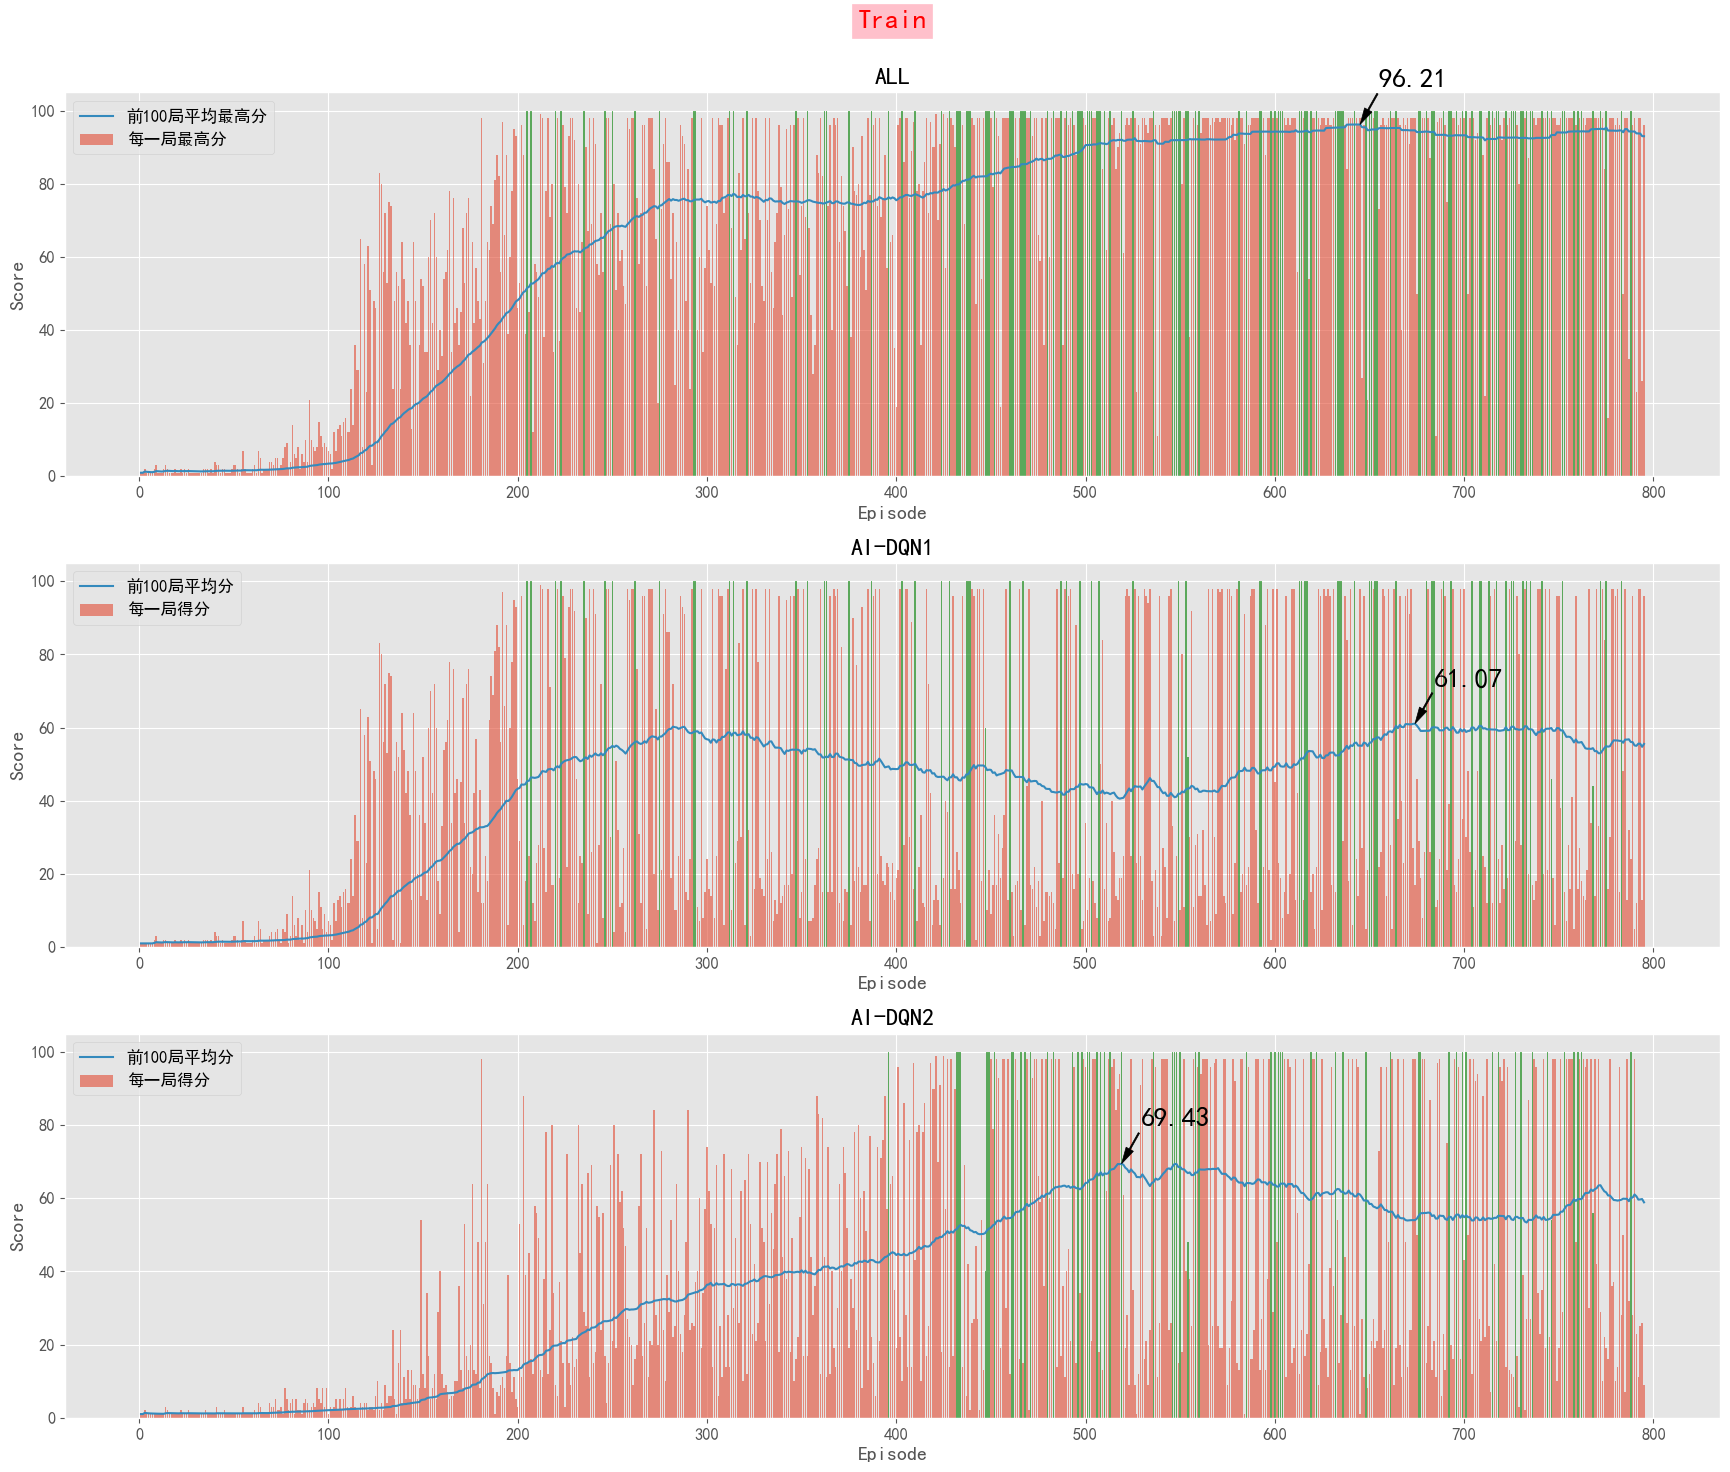

In [3]:
# plot data
progress1 = torch.load(f"checkpoints/training_progress_number1.pth",weights_only=False,map_location='cpu')
progress2 = torch.load(f"checkpoints/training_progress_number2.pth",weights_only=False,map_location='cpu')
random_state = torch.load(f"checkpoints/random_states.pth",weights_only=False,map_location='cpu')

data=pd.DataFrame({
    'AI-DQN1_score':progress1['info_map']['score'],'AI-DQN2_score':progress2['info_map']['score'],
    'AI-DQN1_mean_score':progress1['info_map']['mean_score'],'AI-DQN2_mean_score':progress2['info_map']['mean_score'],
    'episode_max_score':random_state['episode_info']['max_score'],'episode_mean_max_score':random_state['episode_info']['mean_max_score'],
    }).reset_index().rename(columns={'index':'episode'})
data['episode']+=1
data['AI-DQN1_reason']=data['episode'].apply(lambda x:','.join([i for i in list(progress1['info_map']['step_info_history'][x-1][x].items())[-1][1].keys() if i not in ['done','victory']]))
data['AI-DQN2_reason']=data['episode'].apply(lambda x:','.join([i for i in list(progress2['info_map']['step_info_history'][x-1][x].items())[-1][1].keys() if i not in ['done','victory']]))

data['episode_max_score']=data.apply(lambda x: x[f'AI-DQN1_score']+x[f'AI-DQN2_score'] if '通关游戏' in x[f'AI-DQN1_reason'] and '通关游戏' in x[f'AI-DQN2_reason'] else (x[f'AI-DQN1_score'] if '通关游戏' in x[f'AI-DQN1_reason'] else (x[f'AI-DQN2_score'] if '通关游戏' in x[f'AI-DQN2_reason'] else max(x[f'AI-DQN1_score'],x[f'AI-DQN2_score']))),axis=1)
data[f'AI-DQN1_complete']=data[f'AI-DQN1_reason'].str.contains('通关游戏').astype(int)
data[f'AI-DQN2_complete']=data[f'AI-DQN2_reason'].str.contains('通关游戏').astype(int)
data['episode_complete']=data[[f'AI-DQN1_complete',f'AI-DQN2_complete']].any(axis=1).astype(int)

first_complete1=data.set_index('episode')[f'AI-DQN1_complete'].idxmax().item()
first_complete2=data.set_index('episode')[f'AI-DQN2_complete'].idxmax().item()
first_complete_1=min(first_complete1,first_complete2)
print(f'AI-DQN1 首次通关:',first_complete1)
print(f'AI-DQN2 首次通关:',first_complete2)
print(f'ALL 首次通关:',first_complete_1)
print('')
print('AI-DQN1 首次通关后的平均得分:',data[data['episode']>=first_complete1]['AI-DQN1_score'].mean())
print('AI-DQN2 首次通关后的平均得分:',data[data['episode']>=first_complete2]['AI-DQN2_score'].mean())
print('ALL 首次通关后的平均得分:',data[data['episode']>=first_complete_1]['episode_max_score'].mean())
print('')
print('AI-DQN1 首次通关后的通关率:',data[data['episode']>=first_complete1]['AI-DQN1_complete'].sum().item()/len(data[data['episode']>=first_complete1]))
print('AI-DQN2 首次通关后的通关率:',data[data['episode']>=first_complete2]['AI-DQN2_complete'].sum().item()/len(data[data['episode']>=first_complete2]))
print('ALL 首次通关后的通关率:',data[data['episode']>=first_complete_1]['episode_complete'].sum().item()/len(data[data['episode']>=first_complete_1]))
print('')

for number in [1,2,-1]:
    for score in [98,95,90]:
        if number != -1:
            first_complete=first_complete1 if number == 1 else first_complete2
            print(f'AI-DQN{number} 首次通关后>={score}分率:',(data[data['episode']>=first_complete][f'AI-DQN{number}_score']>=score).sum().item()/len(data[data['episode']>=first_complete]))
        else:
            print(f'ALL 首次通关后>={score}分率:',(data[data['episode']>=first_complete_1]['episode_max_score']>=score).sum().item()/len(data[data['episode']>=first_complete_1]))

print('')
print(f'AI-DQN1 胜率:',(data[f'AI-DQN1_score'] > data[f'AI-DQN2_score']).sum().item()/len(data))
print(f'AI-DQN2 胜率:',(data[f'AI-DQN1_score'] < data[f'AI-DQN2_score']).sum().item()/len(data))

fig,ax=plt.subplots(3,1,figsize=(18,15))
ax[0].bar(data['episode'],data['episode_max_score'],alpha=0.6,label='每一局最高分',color=data.apply(lambda x:'green' if '通关游戏' in x['AI-DQN1_reason']+x['AI-DQN2_reason'] else 'C0',axis=1))
ax[0].plot(data['episode'],data['episode_mean_max_score'],label='前100局平均最高分',color='C1')
y=data['episode_mean_max_score'].max()
x=data[data['episode_mean_max_score']==y]['episode'].max()
ax[0].annotate(f"{y:.2f}",xy=(x, y),xytext=(x+10, y+10),color='black',size=20,arrowprops=dict(color='black',width=1,headwidth=6))
ax[0].legend()
ax[0].set_title('ALL')
ax[0].set_xlabel('Episode')
ax[0].set_ylabel('Score')

ax[1].bar(data['episode'],data['AI-DQN1_score'],alpha=0.6,label='每一局得分',color=data['AI-DQN1_reason'].apply(lambda x:'green' if '通关游戏' in x else 'C0'))
ax[1].plot(data['episode'],data['AI-DQN1_mean_score'],label='前100局平均分',color='C1')
y=data['AI-DQN1_mean_score'].max()
x=data[data['AI-DQN1_mean_score']==y]['episode'].max()
ax[1].annotate(f"{y:.2f}",xy=(x, y),xytext=(x+10, y+10),color='black',size=20,arrowprops=dict(color='black',width=1,headwidth=6))
ax[1].legend()
ax[1].set_title('AI-DQN1')
ax[1].set_xlabel('Episode')
ax[1].set_ylabel('Score')

ax[2].bar(data['episode'],data['AI-DQN2_score'],alpha=0.6,label='每一局得分',color=data['AI-DQN2_reason'].apply(lambda x:'green' if '通关游戏' in x else 'C0'))
ax[2].plot(data['episode'],data['AI-DQN2_mean_score'],label='前100局平均分',color='C1')
y=data['AI-DQN2_mean_score'].max()
x=data[data['AI-DQN2_mean_score']==y]['episode'].max()
ax[2].annotate(f"{y:.2f}",xy=(x, y),xytext=(x+10, y+10),color='black',size=20,arrowprops=dict(color='black',width=1,headwidth=6))
ax[2].legend()
ax[2].set_title('AI-DQN2')
ax[2].set_xlabel('Episode')
ax[2].set_ylabel('Score')

plt.suptitle('Train',fontsize=20,color='red',backgroundcolor='pink',fontweight='bold')
plt.tight_layout(rect=(0,0,0.97,0.98))
# plt.savefig('train.png')
plt.show()

data_path='./test/10x10'
AI-DQN1 VS AI-DQN2

平均得分: AI-DQN1_score        58.14
AI-DQN2_score        56.62
episode_max_score    94.56
dtype: float64

通关率: AI-DQN1_complete    0.23
AI-DQN2_complete    0.12
episode_complete    0.35
dtype: float64

AI-DQN1 >=98: 0.38
AI-DQN1 >=95: 0.48
AI-DQN1 >=90: 0.49
AI-DQN2 >=98: 0.3
AI-DQN2 >=95: 0.41
AI-DQN2 >=90: 0.43
ALL >=98: 0.68
ALL >=95: 0.89
ALL >=90: 0.92

AI-DQN1 胜率: 0.51
AI-DQN2 胜率: 0.49


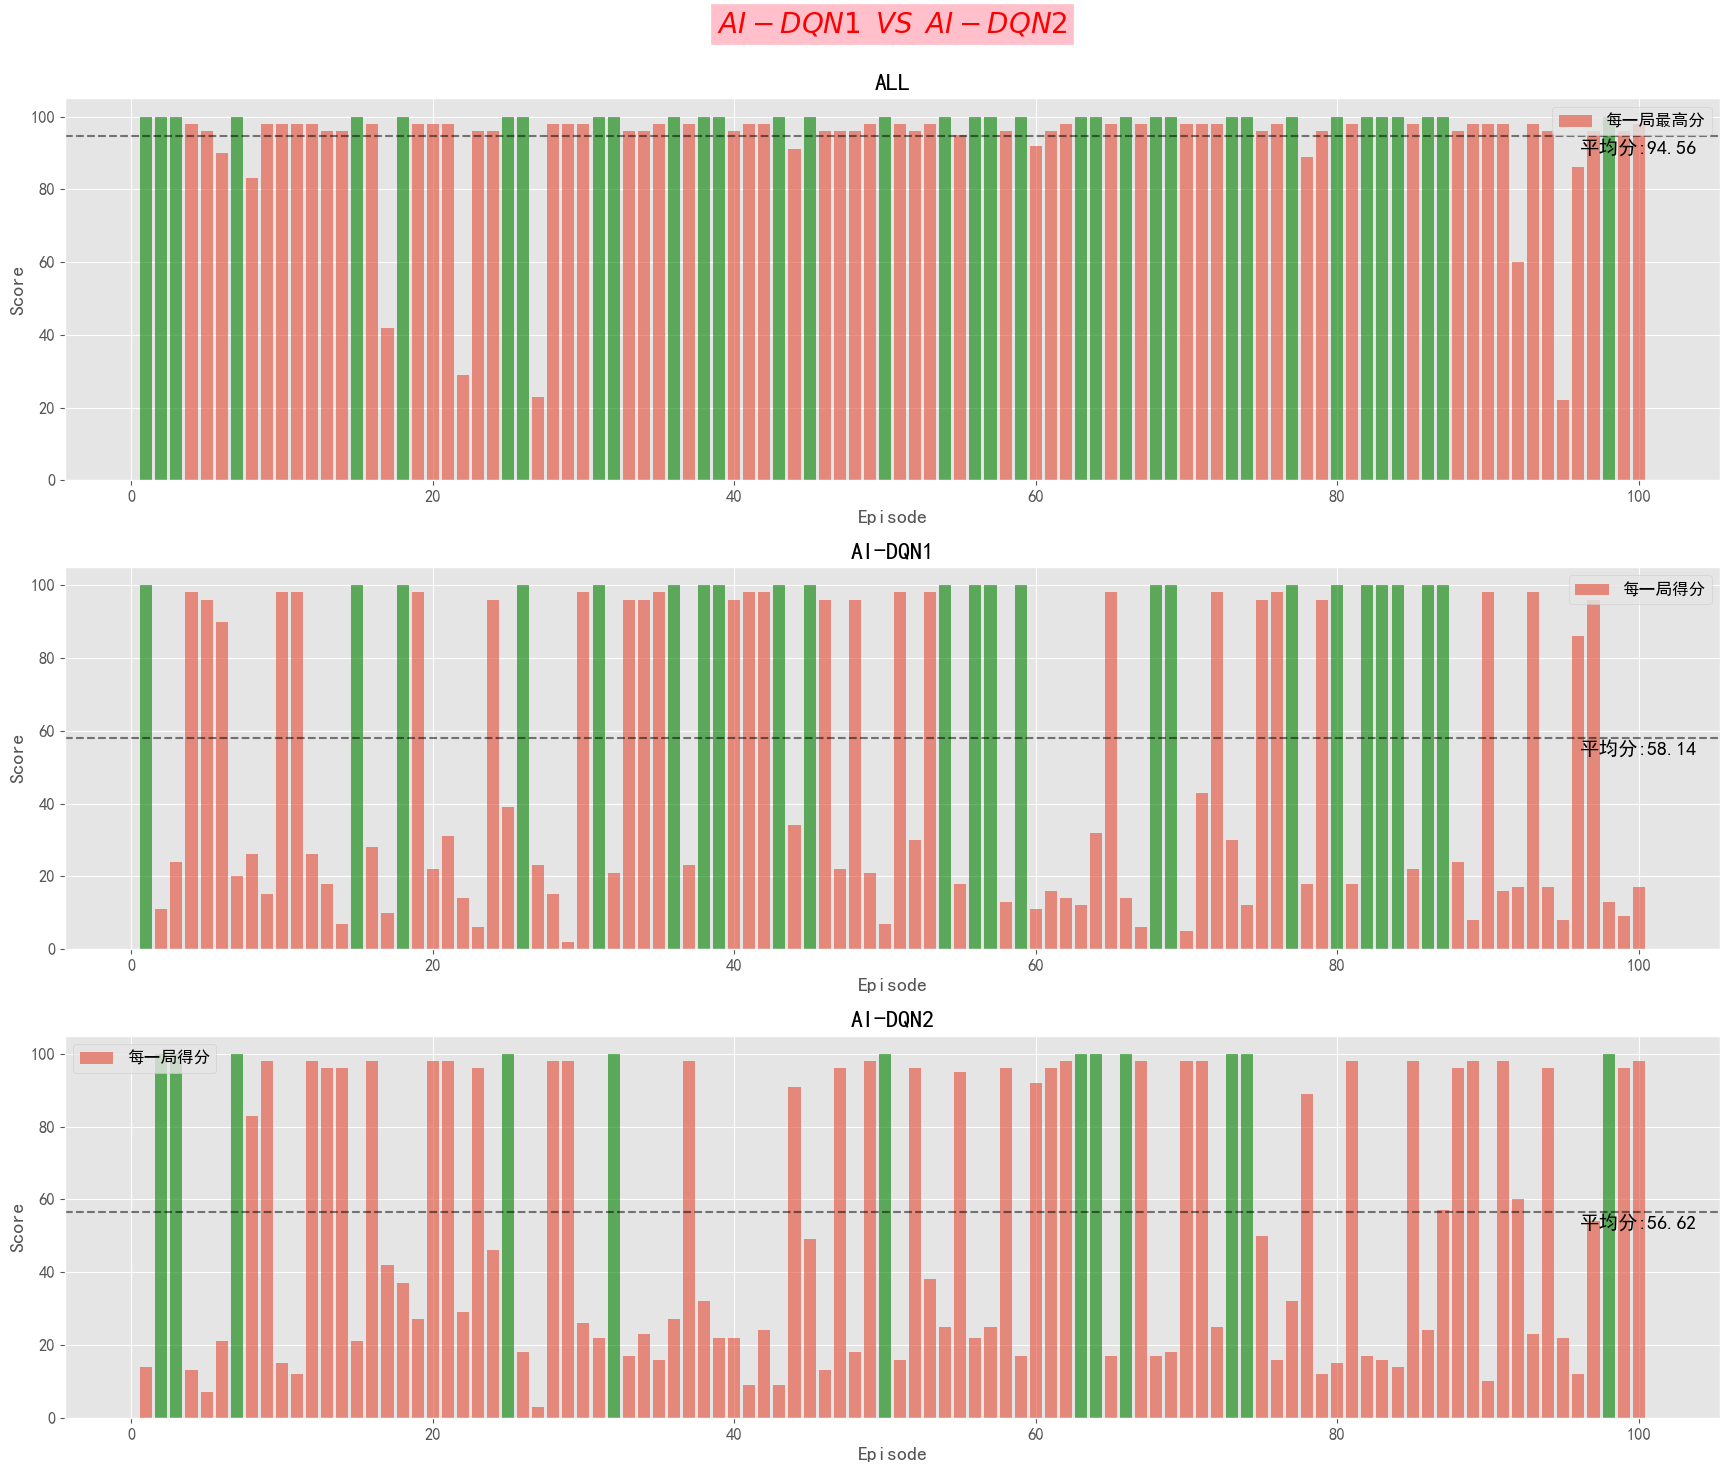

AI-DQN1 VS Rule-BFS

平均得分: AI-DQN1_score        53.26
Rule-BFS_score       53.96
episode_max_score    91.74
dtype: float64

通关率: AI-DQN1_complete     0.23
Rule-BFS_complete    0.05
episode_complete     0.27
dtype: float64

AI-DQN1 >=98: 0.41
AI-DQN1 >=95: 0.43
AI-DQN1 >=90: 0.44
Rule-BFS >=98: 0.22
Rule-BFS >=95: 0.35
Rule-BFS >=90: 0.42
ALL >=98: 0.64
ALL >=95: 0.79
ALL >=90: 0.87

AI-DQN1 胜率: 0.47
Rule-BFS 胜率: 0.5


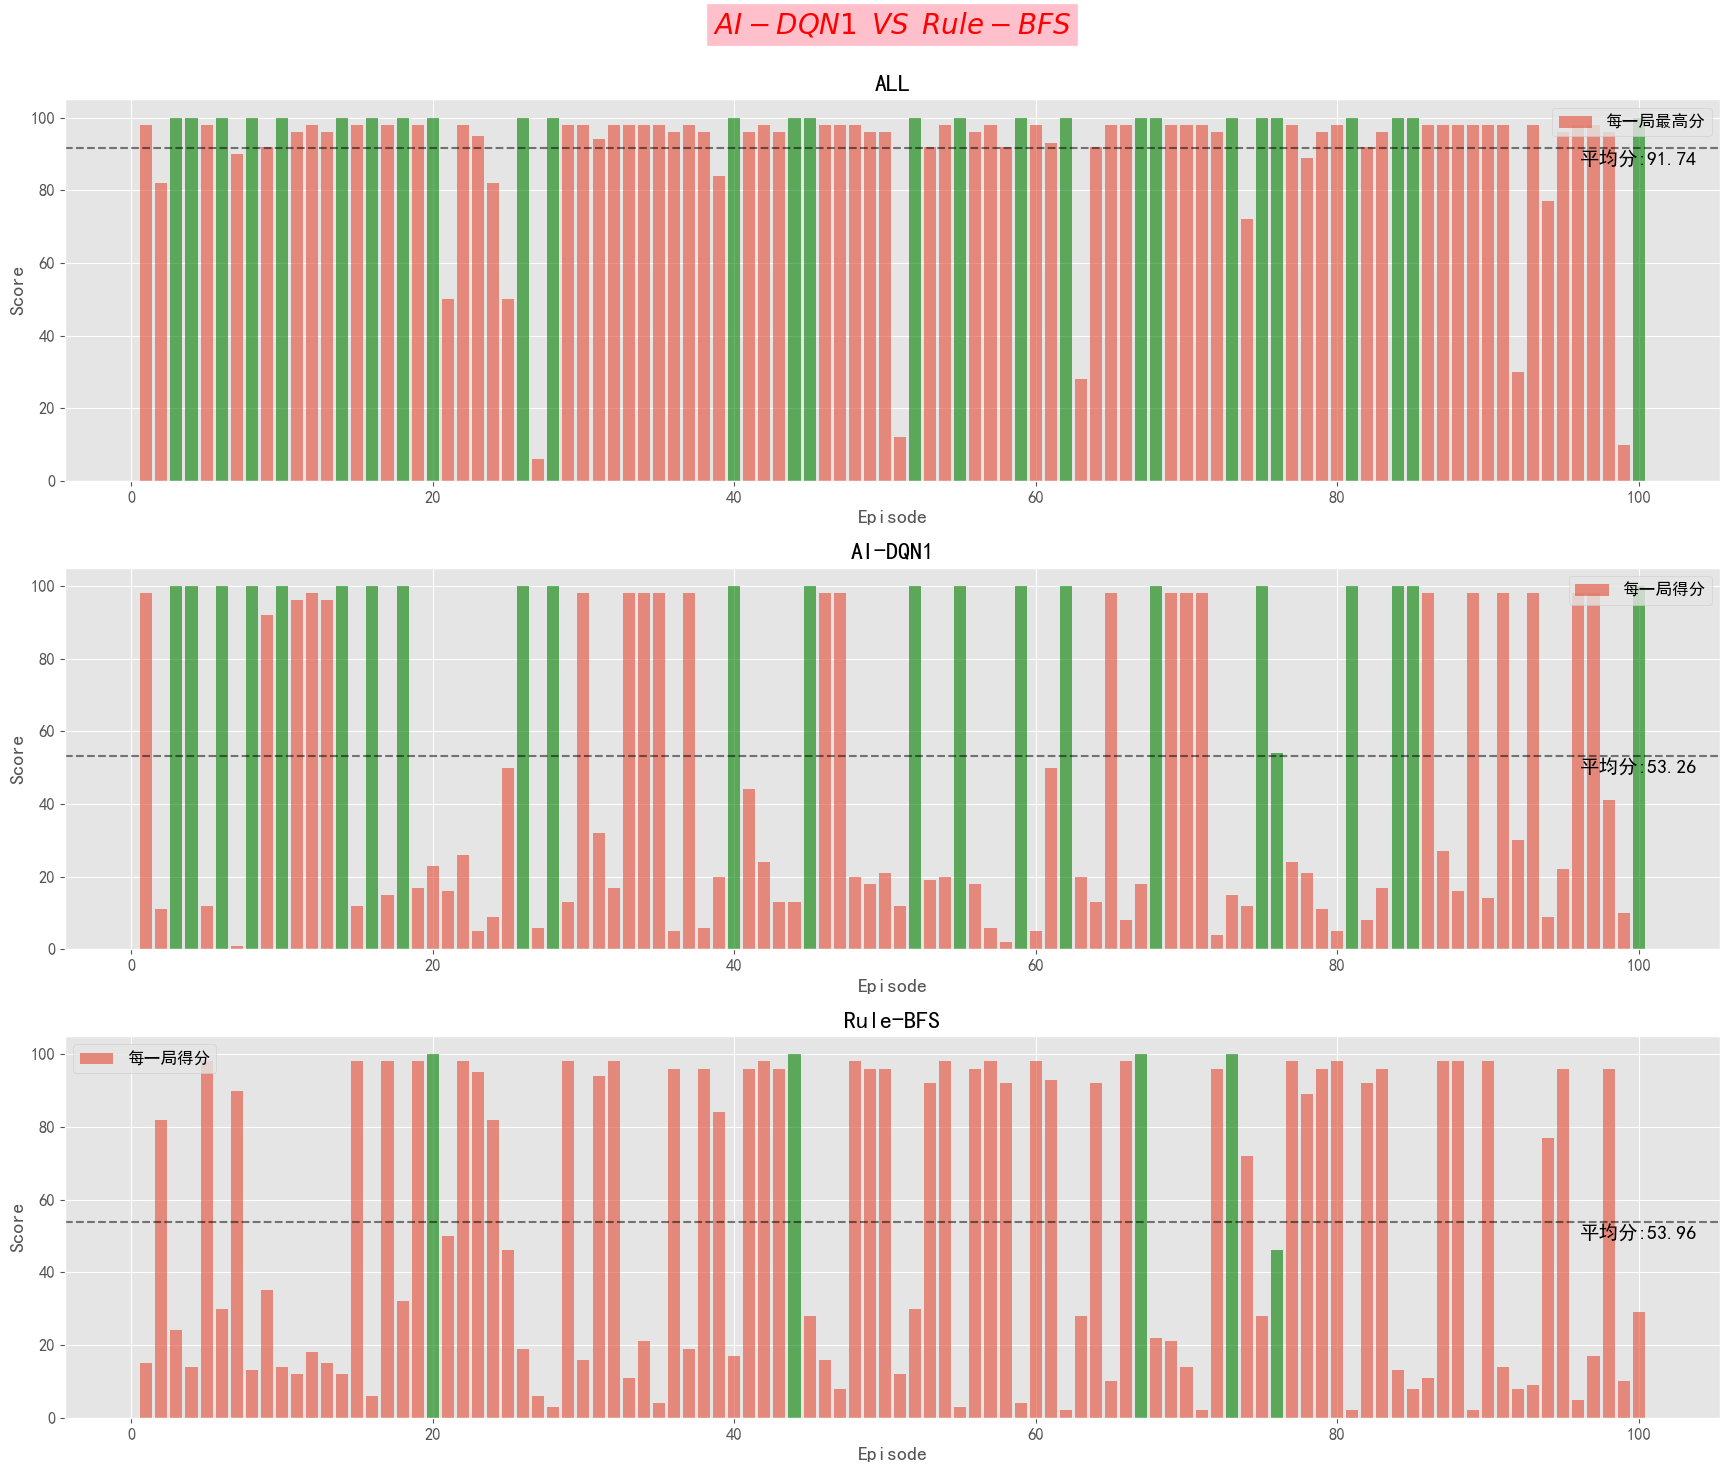

AI-DQN1 单机

平均得分: AI-DQN1_score    95.06
dtype: float64

通关率: AI-DQN1_complete    0.28
dtype: float64

AI-DQN1 >=98: 0.73
AI-DQN1 >=95: 0.91
AI-DQN1 >=90: 0.95


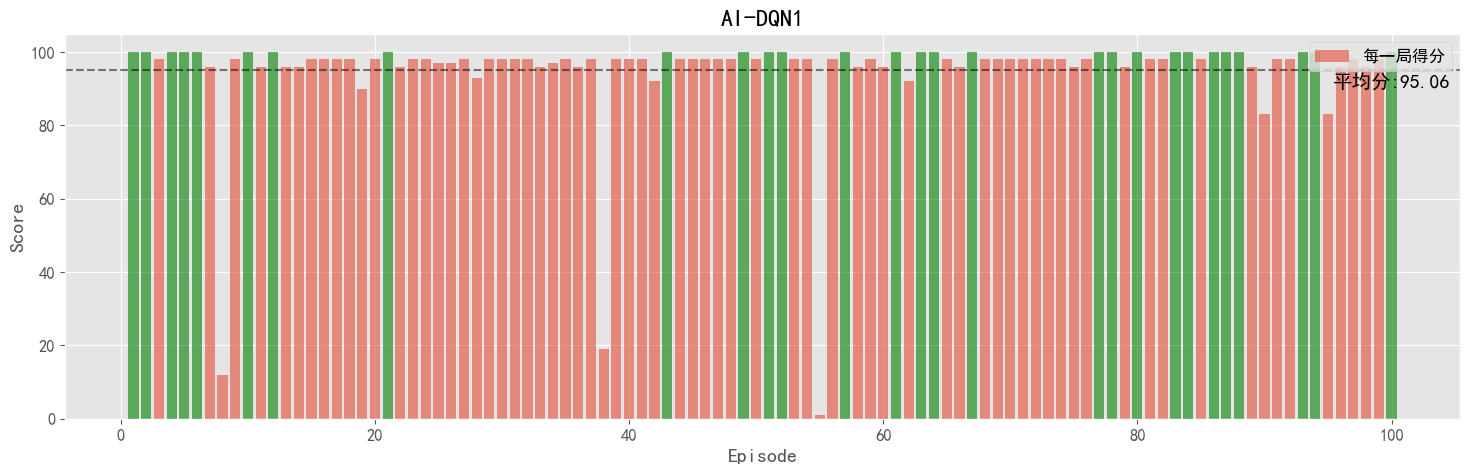

AI-DQN2 单机

平均得分: AI-DQN2_score    80.83
dtype: float64

通关率: AI-DQN2_complete    0.32
dtype: float64

AI-DQN2 >=98: 0.59
AI-DQN2 >=95: 0.75
AI-DQN2 >=90: 0.76


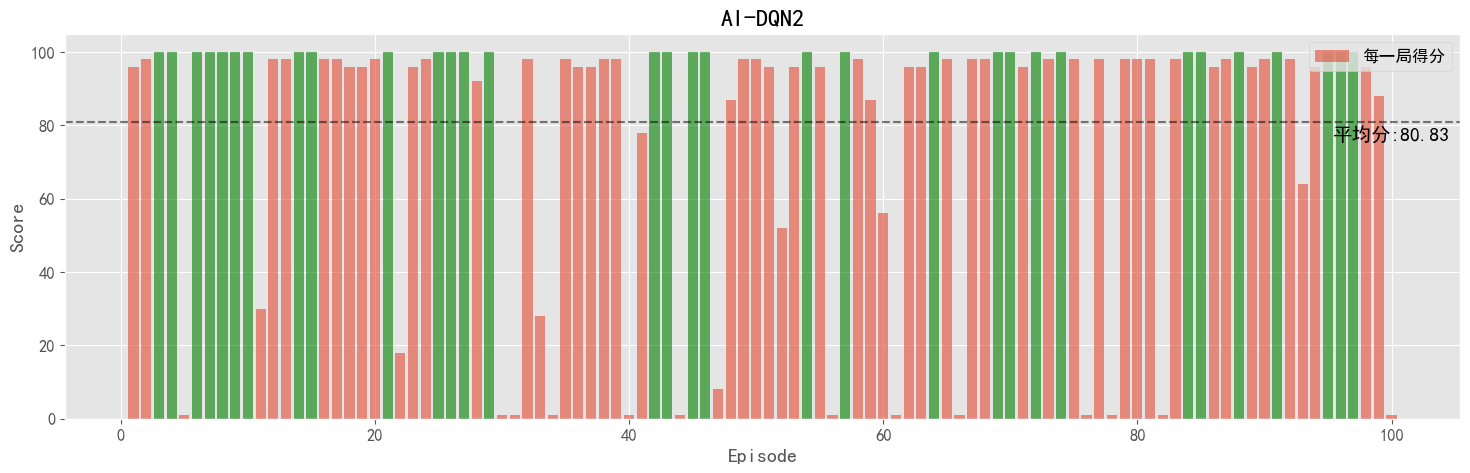

Rule-BFS VS AI-DQN2

平均得分: AI-DQN2_score        63.63
Rule-BFS_score       45.29
episode_max_score    91.79
dtype: float64

通关率: Rule-BFS_complete    0.04
AI-DQN2_complete     0.26
episode_complete     0.30
dtype: float64

Rule-BFS >=98: 0.19
Rule-BFS >=95: 0.26
Rule-BFS >=90: 0.33
AI-DQN2 >=98: 0.48
AI-DQN2 >=95: 0.53
AI-DQN2 >=90: 0.55
ALL >=98: 0.67
ALL >=95: 0.79
ALL >=90: 0.88

Rule-BFS 胜率: 0.38
AI-DQN2 胜率: 0.59


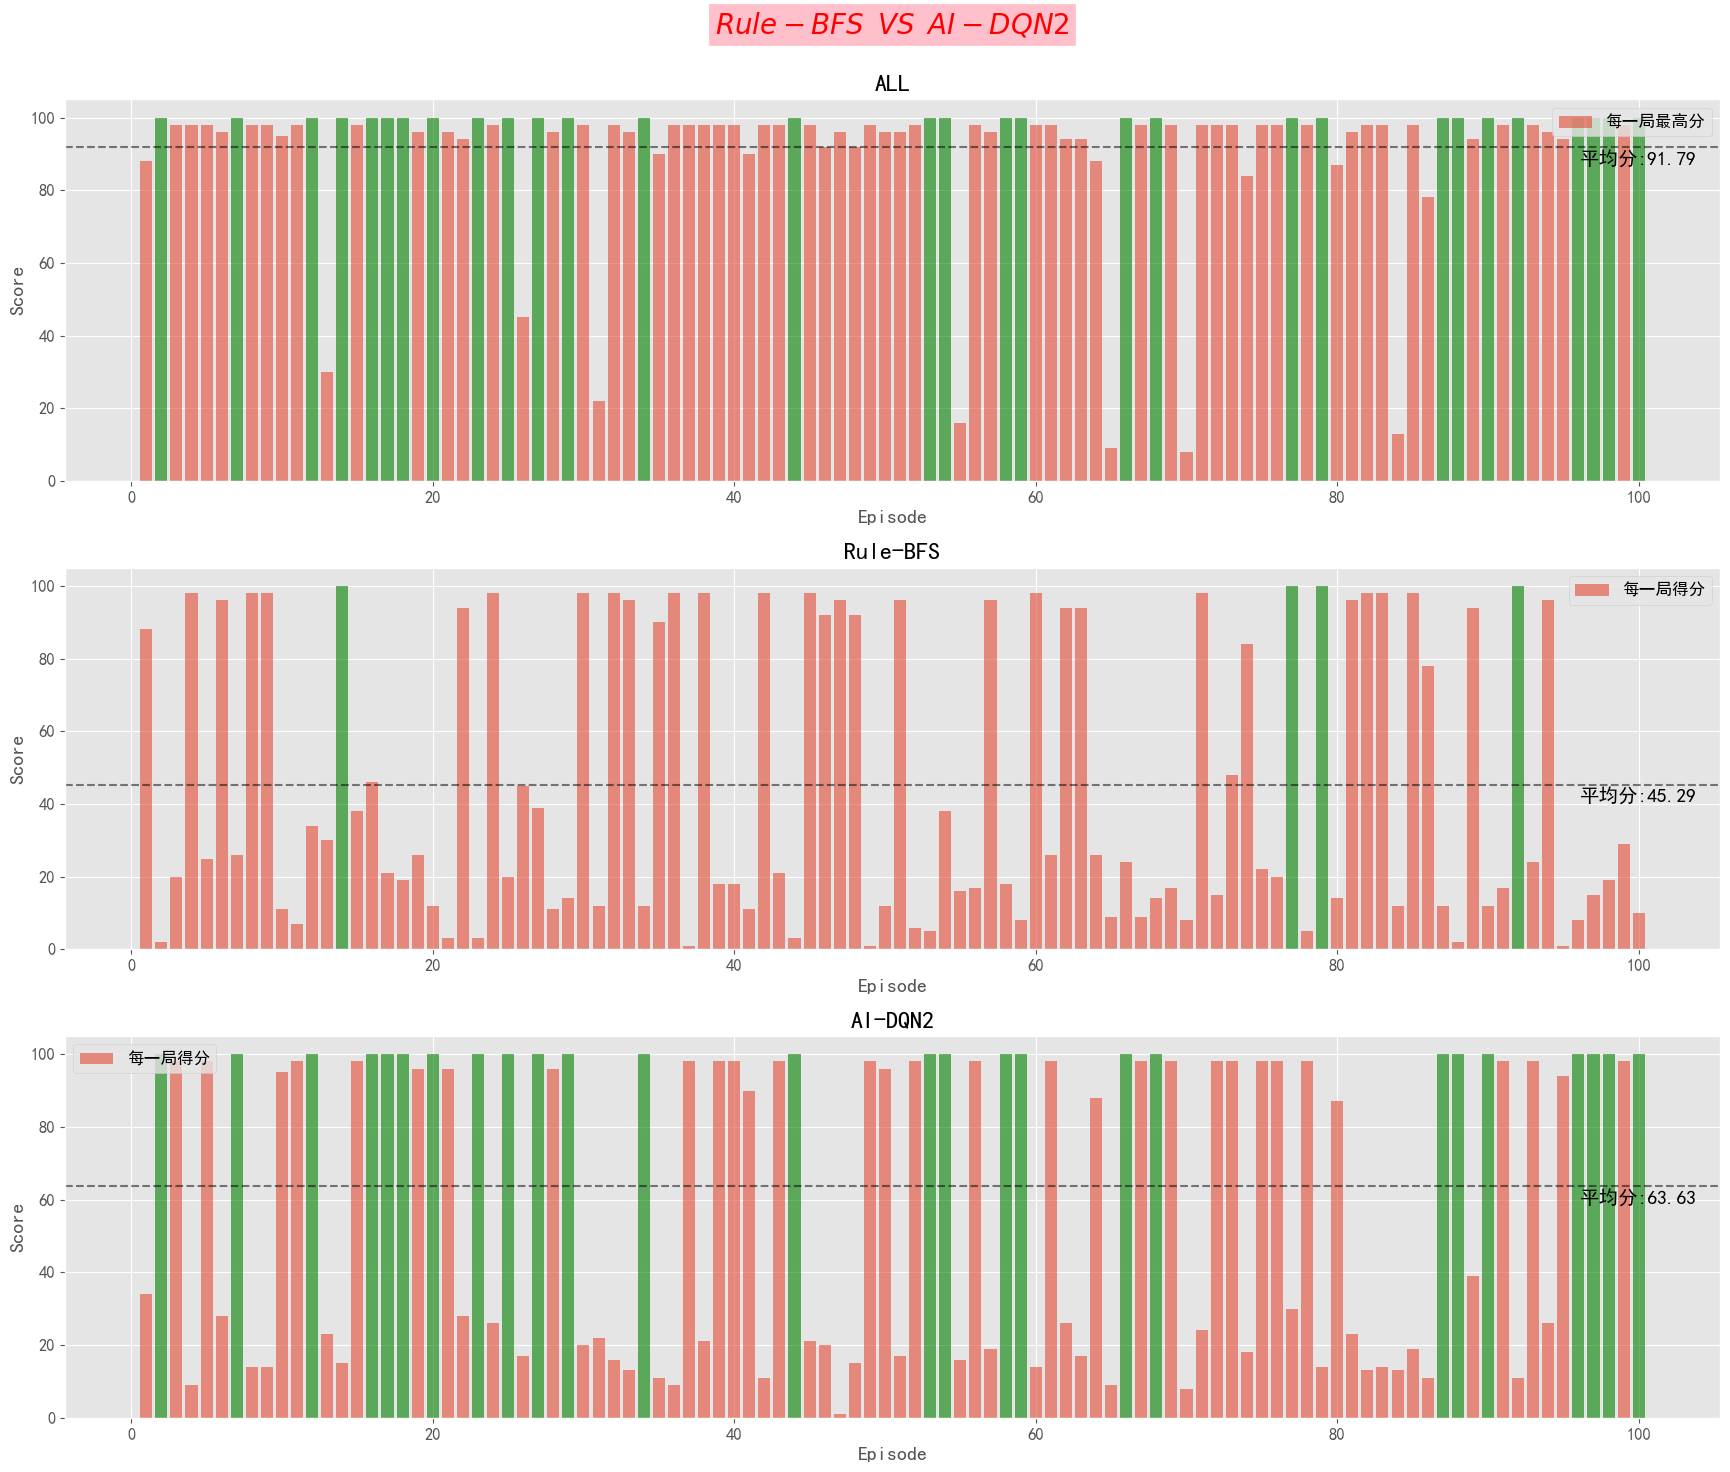

Rule-BFS 单机

平均得分: Rule-BFS_score    96.06
dtype: float64

通关率: Rule-BFS_complete    0.17
dtype: float64

Rule-BFS >=98: 0.53
Rule-BFS >=95: 0.75
Rule-BFS >=90: 0.94


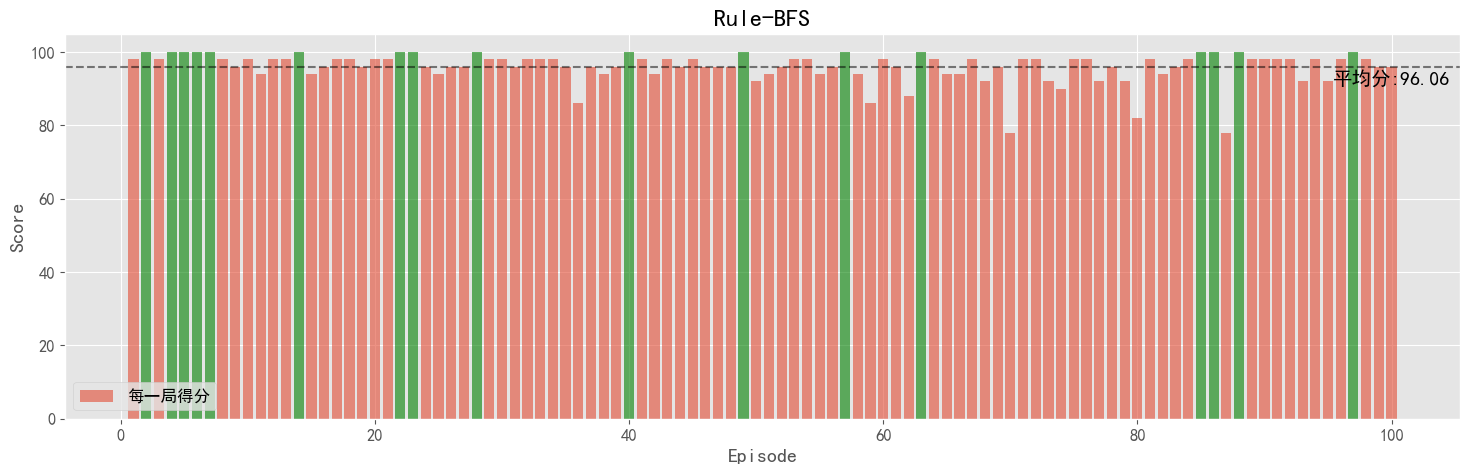

data_path='./test/20x20'
AI-DQN1 VS AI-DQN2

平均得分: AI-DQN1_score        191.50
AI-DQN2_score        214.90
episode_max_score    368.62
dtype: float64

通关率: AI-DQN1_complete    0.01
AI-DQN2_complete    0.06
episode_complete    0.07
dtype: float64

AI-DQN1 >=390: 0.31
AI-DQN1 >=370: 0.33
AI-DQN1 >=350: 0.4
AI-DQN2 >=390: 0.37
AI-DQN2 >=370: 0.42
AI-DQN2 >=350: 0.47
ALL >=390: 0.68
ALL >=370: 0.75
ALL >=350: 0.87

AI-DQN1 胜率: 0.45
AI-DQN2 胜率: 0.55


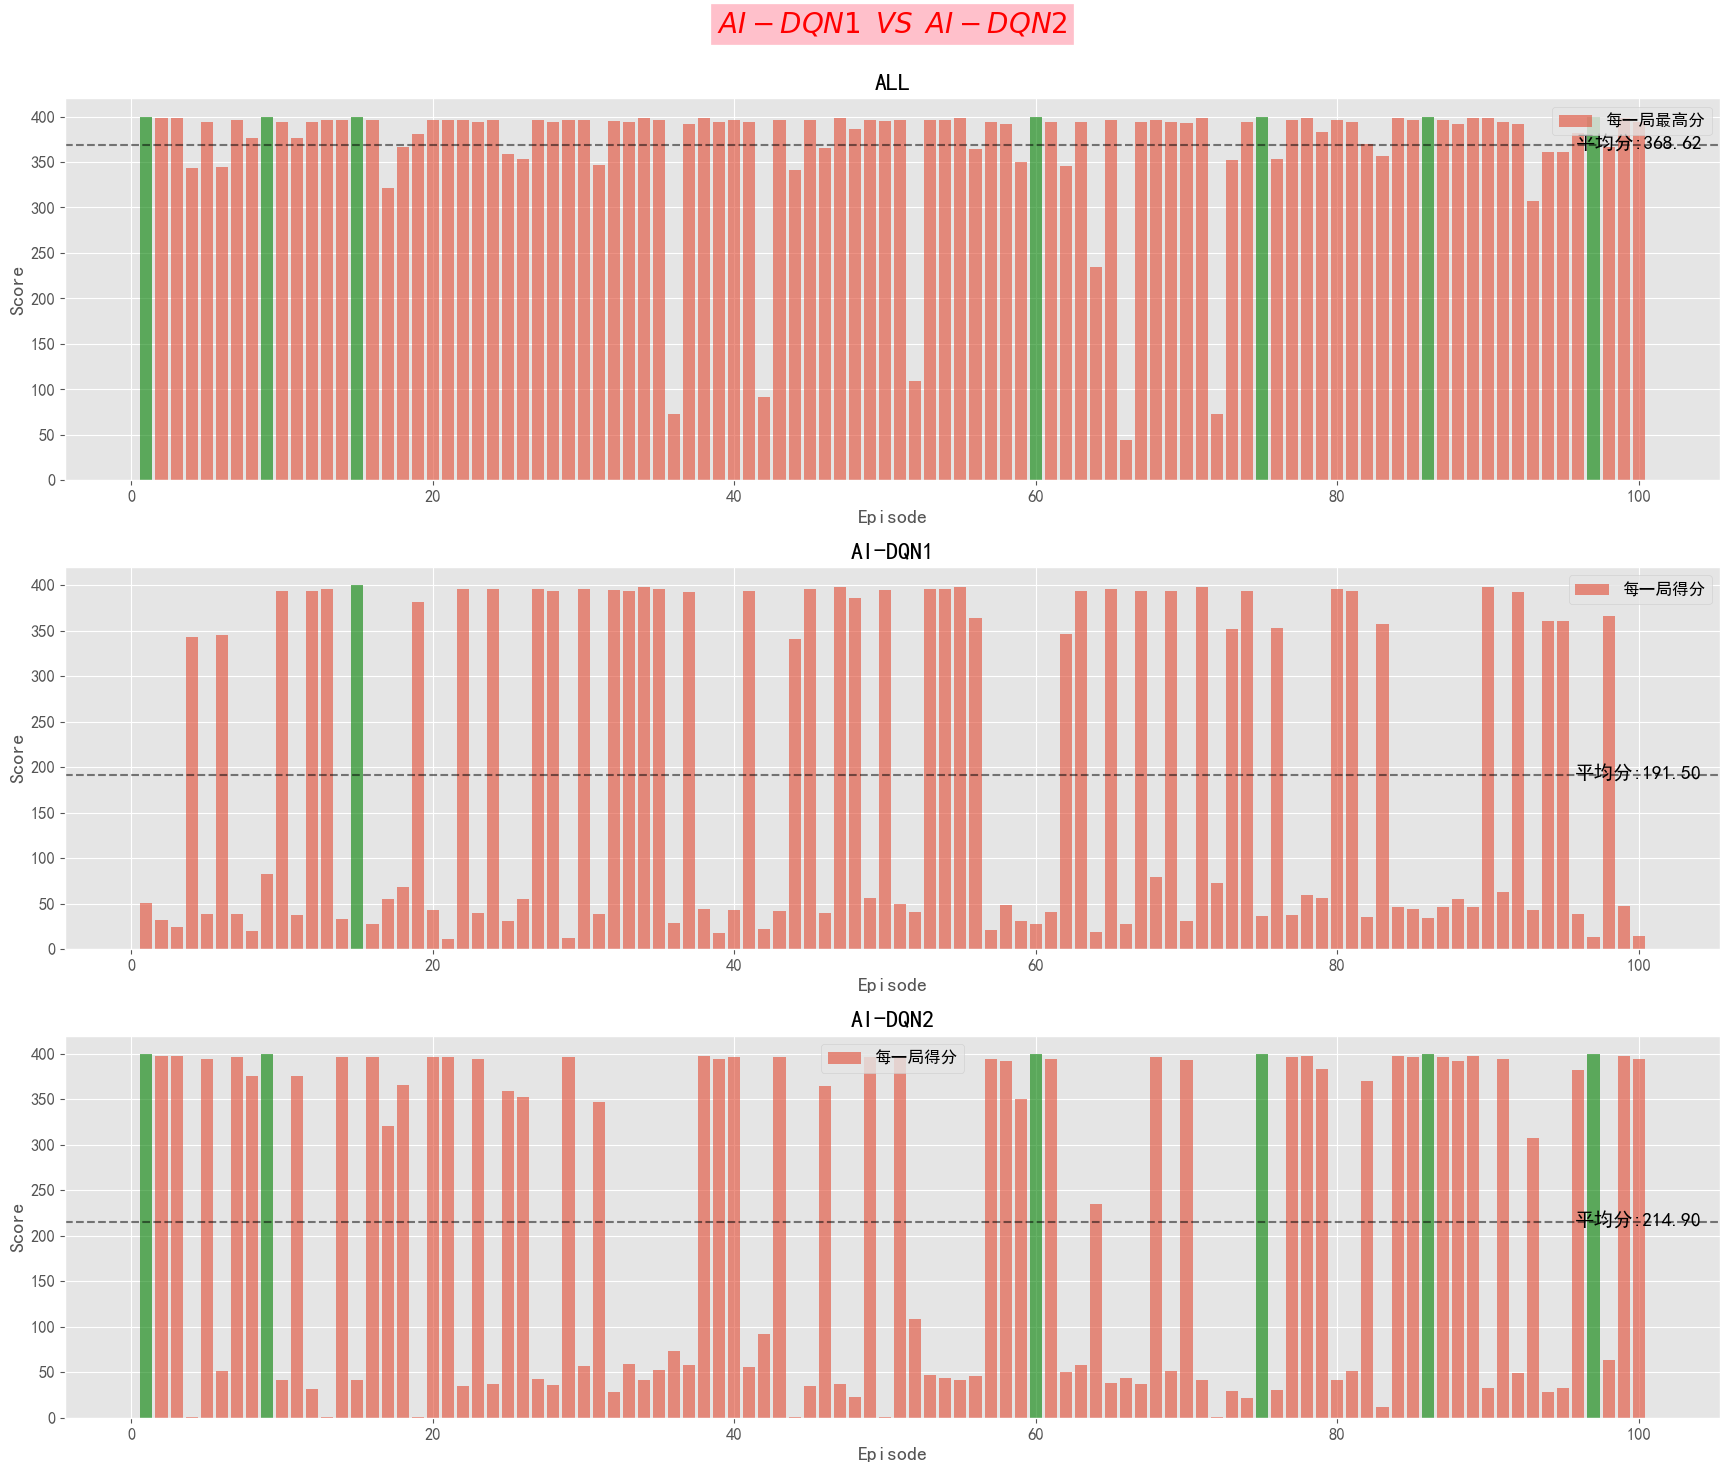

AI-DQN1 VS Rule-BFS

平均得分: AI-DQN1_score        180.22
Rule-BFS_score       219.79
episode_max_score    363.70
dtype: float64

通关率: AI-DQN1_complete     0.02
Rule-BFS_complete    0.00
episode_complete     0.02
dtype: float64

AI-DQN1 >=390: 0.24
AI-DQN1 >=370: 0.33
AI-DQN1 >=350: 0.36
Rule-BFS >=390: 0.24
Rule-BFS >=370: 0.49
Rule-BFS >=350: 0.51
ALL >=390: 0.48
ALL >=370: 0.82
ALL >=350: 0.87

AI-DQN1 胜率: 0.42
Rule-BFS 胜率: 0.56


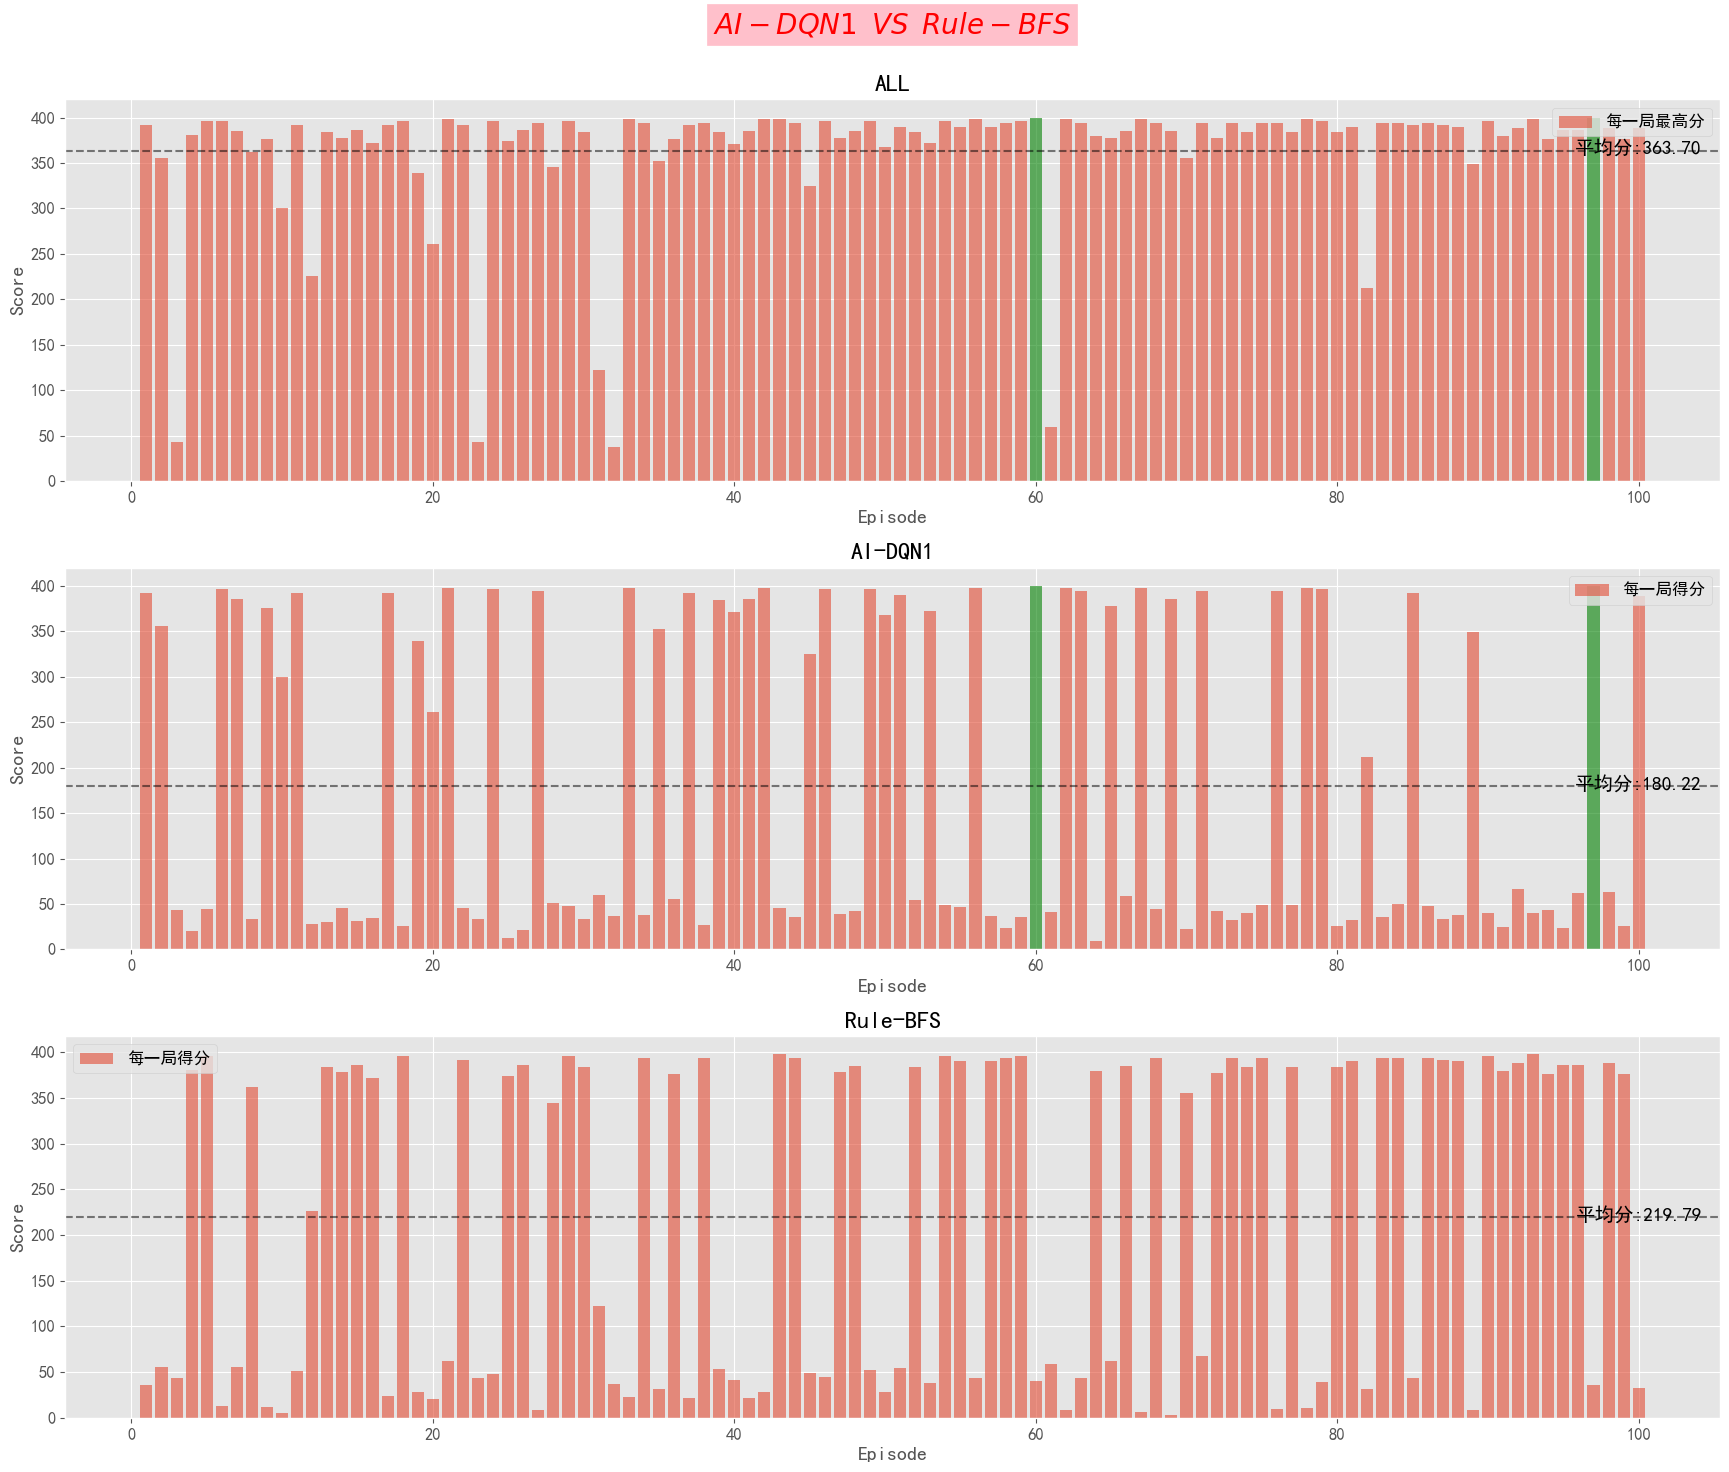

AI-DQN1 单机

平均得分: AI-DQN1_score    356.96
dtype: float64

通关率: AI-DQN1_complete    0.03
dtype: float64

AI-DQN1 >=390: 0.62
AI-DQN1 >=370: 0.7
AI-DQN1 >=350: 0.77


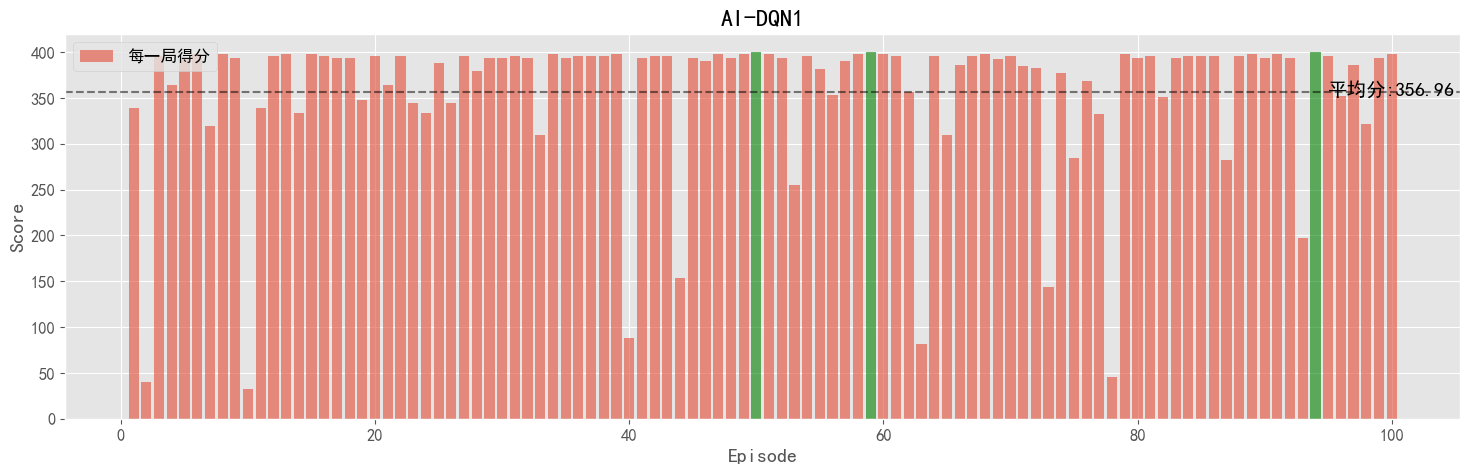

AI-DQN2 单机

平均得分: AI-DQN2_score    275.13
dtype: float64

通关率: AI-DQN2_complete    0.02
dtype: float64

AI-DQN2 >=390: 0.5
AI-DQN2 >=370: 0.59
AI-DQN2 >=350: 0.64


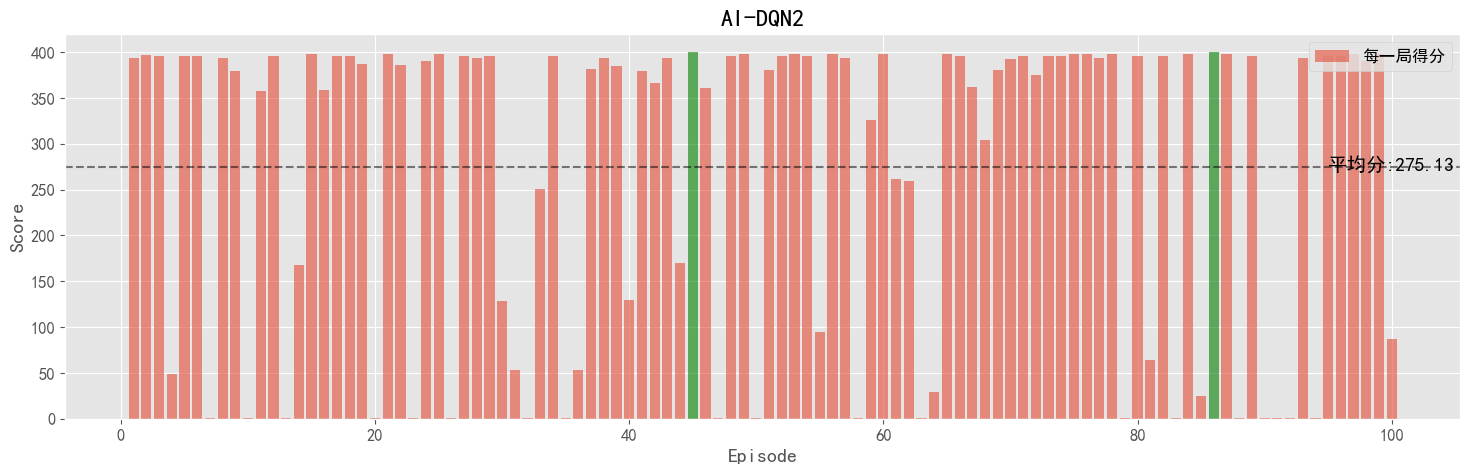

Rule-BFS VS AI-DQN2

平均得分: AI-DQN2_score        194.89
Rule-BFS_score       206.65
episode_max_score    367.68
dtype: float64

通关率: Rule-BFS_complete    0.00
AI-DQN2_complete     0.02
episode_complete     0.02
dtype: float64

Rule-BFS >=390: 0.19
Rule-BFS >=370: 0.44
Rule-BFS >=350: 0.49
AI-DQN2 >=390: 0.32
AI-DQN2 >=370: 0.37
AI-DQN2 >=350: 0.39
ALL >=390: 0.51
ALL >=370: 0.81
ALL >=350: 0.88

Rule-BFS 胜率: 0.51
AI-DQN2 胜率: 0.48


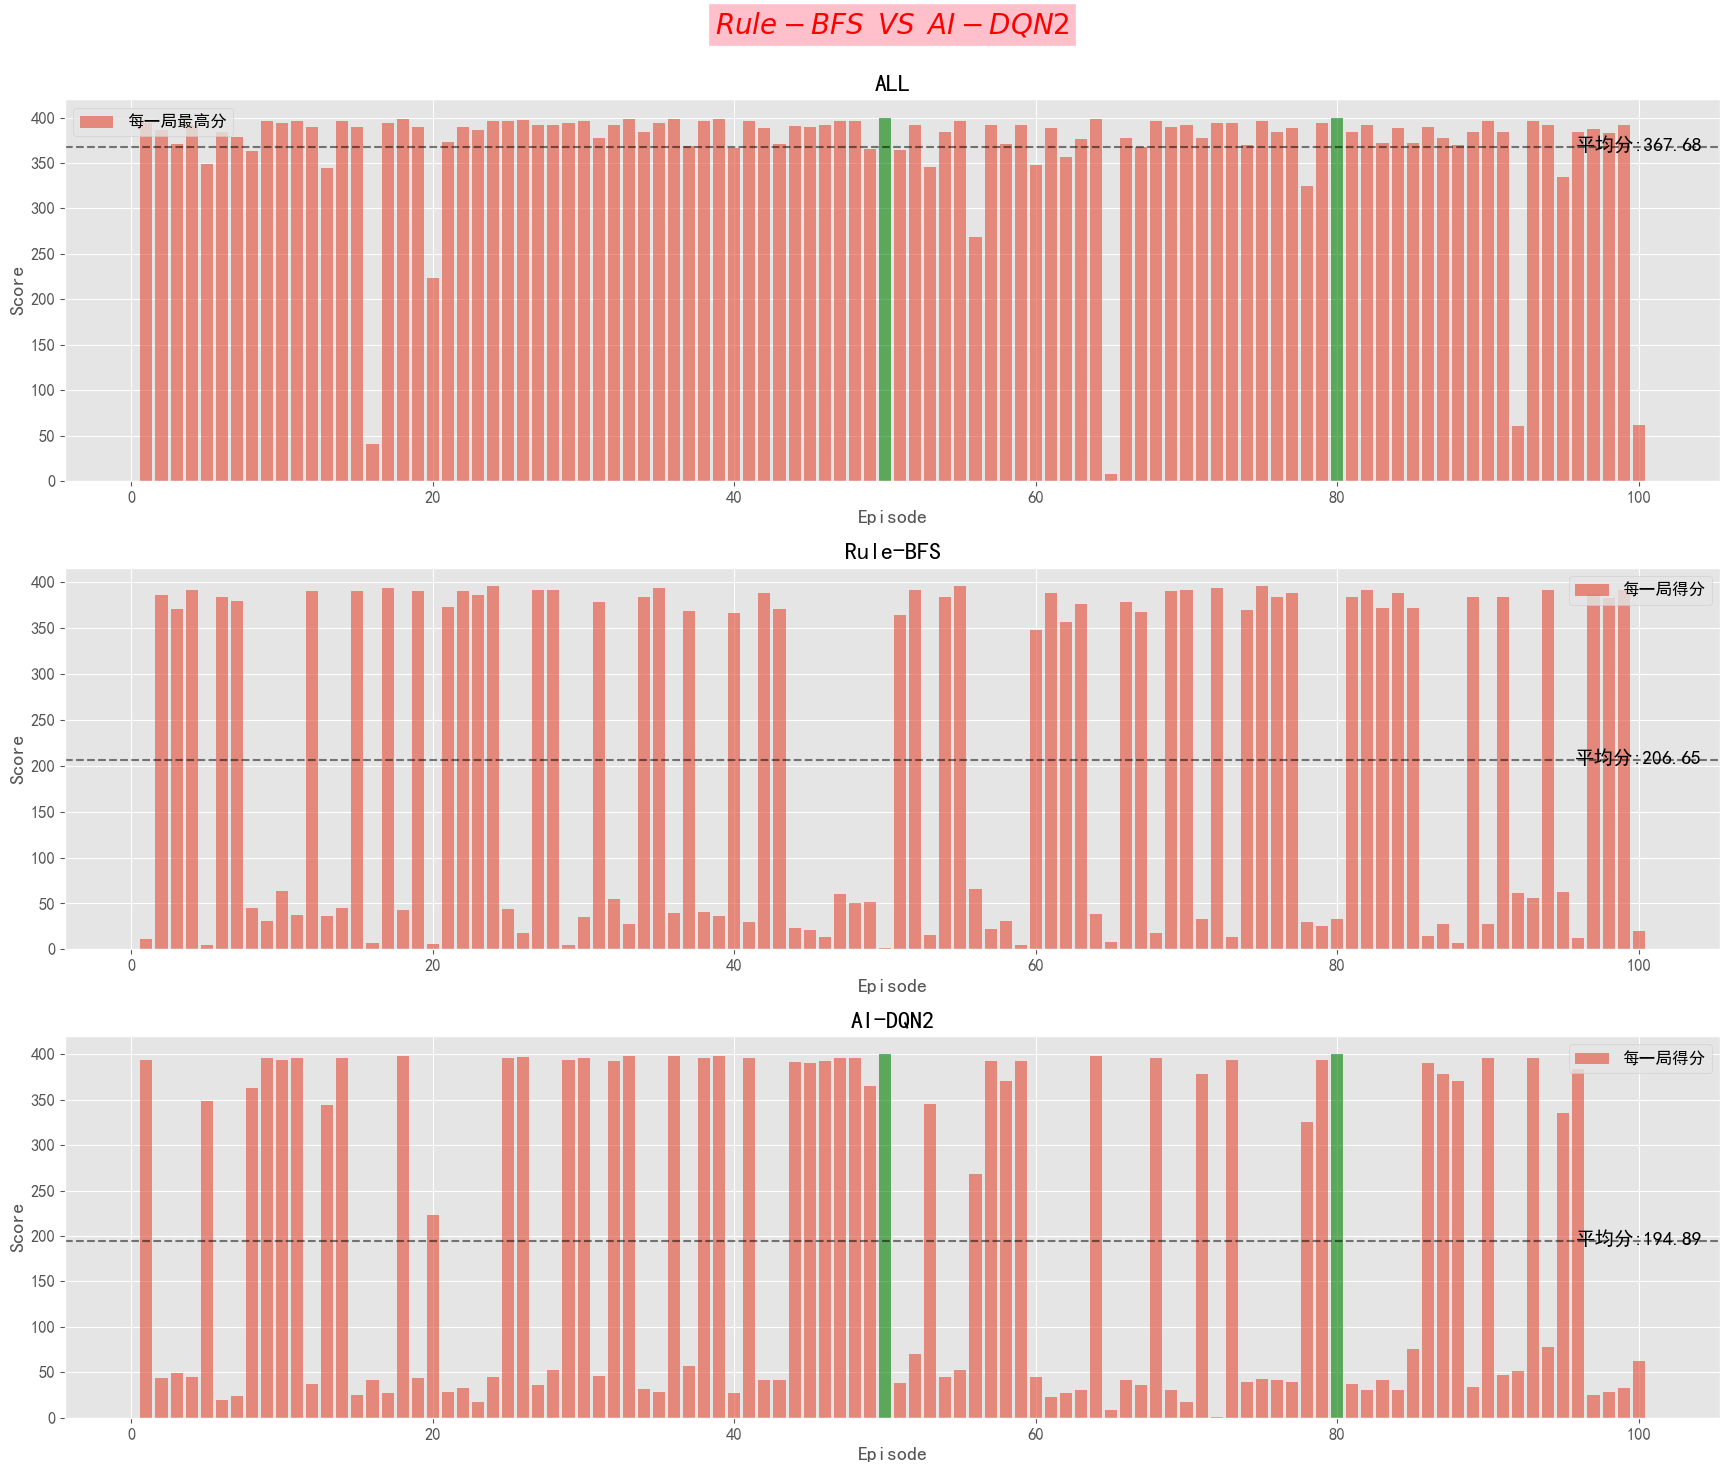

Rule-BFS 单机

平均得分: Rule-BFS_score    381.88
dtype: float64

通关率: Rule-BFS_complete    0.0
dtype: float64

Rule-BFS >=390: 0.36
Rule-BFS >=370: 0.84
Rule-BFS >=350: 0.96


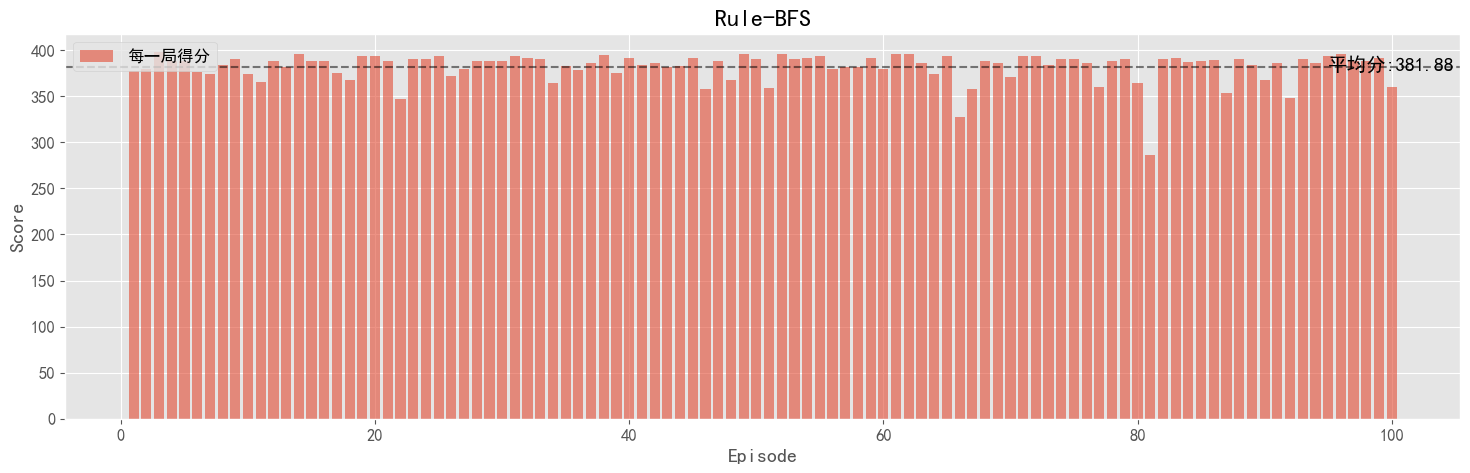

In [4]:
play_maps={
    'AI-DQN1 单机':{1:{'player':'AI-DQN1'},2:{}},
    'AI-DQN2 单机':{1:{'player':'AI-DQN2'},2:{}},
    'Rule-BFS 单机':{1:{'player':'Rule-BFS'},2:{}},
    'AI-DQN1 VS AI-DQN2':{1:{'player':'AI-DQN1'},2:{'player':'AI-DQN2'}},
    'AI-DQN1 VS Rule-BFS':{1:{'player':'AI-DQN1'},2:{'player':'Rule-BFS'}},
    'Rule-BFS VS AI-DQN2':{1:{'player':'Rule-BFS'},2:{'player':'AI-DQN2'}}
}
test_num=100
for data_path in ['./test/10x10','./test/20x20']:
    print(f'{data_path=}')
    for path in [i for i in os.listdir(data_path) if '.pkl' in i]:
        score_gaps=[98,95,90] if '10x10' in data_path else [390,370,350]
        play_name=path.split('.')[0]
        play_map=play_maps[play_name]
        df=pd.read_pickle(f'{data_path}/{path}')
        df=df.pivot_table(index='episode', columns='Agent', values=['Score','Reason'],aggfunc='first')
        df.columns=[f'{i[1]}_{i[0].lower()}' for i in df.columns]
        df=df.reset_index()
        player_num=[i for i,j in play_map.items() if j.get('player')]
        if len(player_num) == 2:
            df['episode_max_score']=df.apply(lambda x: x[f'{play_map[1]["player"]}_score']+x[f'{play_map[2]["player"]}_score'] if '通关游戏' in x[f'{play_map[1]["player"]}_reason'] and '通关游戏' in x[f'{play_map[2]["player"]}_reason'] else (x[f'{play_map[1]["player"]}_score'] if '通关游戏' in x[f'{play_map[1]["player"]}_reason'] else (x[f'{play_map[2]["player"]}_score'] if '通关游戏' in x[f'{play_map[2]["player"]}_reason'] else max(x[f'{play_map[1]["player"]}_score'],x[f'{play_map[2]["player"]}_score']))),axis=1)
            df[f'{play_map[1]["player"]}_complete']=df[f'{play_map[1]["player"]}_reason'].str.contains('通关游戏').astype(int)
            df[f'{play_map[2]["player"]}_complete']=df[f'{play_map[2]["player"]}_reason'].str.contains('通关游戏').astype(int)
            df['episode_complete']=df[[f'{play_map[1]["player"]}_complete',f'{play_map[2]["player"]}_complete']].any(axis=1).astype(int)
        else:
            df[f'{play_map[player_num[0]]["player"]}_complete']=df[f'{play_map[player_num[0]]["player"]}_reason'].str.contains('通关游戏').astype(int)
        print(f'{play_name}\n')
        print('平均得分:',df[[i for i in df.columns if 'score' in i]].mean())
        print('')
        print('通关率:',df[[i for i in df.columns if 'complete' in i]].sum()/test_num)
        print('')

        if len(player_num) == 2:
            for number in [1,2,-1]:
                for score in score_gaps:
                    if number != -1:
                        print(f'{play_map[number]["player"]} >={score}:',(df[f'{play_map[number]["player"]}_score']>=score).sum().item()/test_num)
                    else:
                        print(f'ALL >={score}:',(df['episode_max_score']>=score).sum().item()/test_num)
        else:
            for number in player_num:
                for score in score_gaps:
                    print(f'{play_map[number]["player"]} >={score}:',(df[f'{play_map[number]["player"]}_score']>=score).sum().item()/test_num)

        if len(player_num) == 2:
            print('')
            print(f'{play_map[1]["player"]} 胜率:',(df[f'{play_map[1]["player"]}_score'] > df[f'{play_map[2]["player"]}_score']).sum().item()/test_num)
            print(f'{play_map[2]["player"]} 胜率:',(df[f'{play_map[1]["player"]}_score'] < df[f'{play_map[2]["player"]}_score']).sum().item()/test_num)

        if len(player_num) == 2:
            fig,ax=plt.subplots(3,1,figsize=(18,15))
            flag=True
            for _,row in df.iterrows():
                color='green' if '通关游戏' in row[f'{play_map[1]["player"]}_reason']+row[f'{play_map[2]["player"]}_reason'] else 'C0'
                if color == 'C0' and flag:
                    flag=False
                    ax[0].bar(row['episode'],row['episode_max_score'],alpha=0.6,label='每一局最高分',color=color)
                else:
                    ax[0].bar(row['episode'],row['episode_max_score'],alpha=0.6,color=color)
            ax[0].axhline(y=df['episode_max_score'].mean(),color='black',linestyle='--',alpha=0.5)
            ax[0].text(test_num,df['episode_max_score'].mean()-5,'平均分:{:.2f}'.format(df['episode_max_score'].mean()),color='black',ha='center',fontsize=14)
            ax[0].legend()
            ax[0].set_title('ALL')
            ax[0].set_xlabel('Episode')
            ax[0].set_ylabel('Score')

            for number in [1,2]:
                flag=True
                for _,row in df.iterrows():
                    color='green' if '通关游戏' in row[f'{play_map[number]["player"]}_reason'] else 'C0'
                    if color == 'C0' and flag:
                        flag=False
                        ax[number].bar(row['episode'],row[f'{play_map[number]["player"]}_score'],alpha=0.6,label='每一局得分',color=color)
                    else:
                        ax[number].bar(row['episode'],row[f'{play_map[number]["player"]}_score'],alpha=0.6,color=color)
                ax[number].axhline(y=df[f'{play_map[number]["player"]}_score'].mean(),color='black',linestyle='--',alpha=0.5)
                ax[number].text(test_num,df[f'{play_map[number]["player"]}_score'].mean()-5,'平均分:{:.2f}'.format(df[f'{play_map[number]["player"]}_score'].mean()),color='black',ha='center',fontsize=14)
                ax[number].legend()
                ax[number].set_title(play_map[number]["player"])
                ax[number].set_xlabel('Episode')
                ax[number].set_ylabel('Score')

            plt.suptitle(f'${play_map[1]["player"]}$ $VS$ ${play_map[2]["player"]}$',fontsize=20,color='red',backgroundcolor='pink',fontweight='bold')
            plt.tight_layout(rect=(0,0,0.97,0.98))
            # plt.savefig(f'{data_path}/{play_name}.png')
            plt.show()
        else:
            fig,ax=plt.subplots(1,1,figsize=(18,5))
            for number in player_num:
                flag=True
                for _,row in df.iterrows():
                    color='green' if '通关游戏' in row[f'{play_map[number]["player"]}_reason'] else 'C0'
                    if color == 'C0' and flag:
                        flag=False
                        ax.bar(row['episode'],row[f'{play_map[number]["player"]}_score'],alpha=0.6,label='每一局得分',color=color)
                    else:
                        ax.bar(row['episode'],row[f'{play_map[number]["player"]}_score'],alpha=0.6,color=color)
                ax.axhline(y=df[f'{play_map[number]["player"]}_score'].mean(),color='black',linestyle='--',alpha=0.5)
                ax.text(test_num,df[f'{play_map[number]["player"]}_score'].mean()-5,'平均分:{:.2f}'.format(df[f'{play_map[number]["player"]}_score'].mean()),color='black',ha='center',fontsize=14)
                ax.legend()
                ax.set_title(play_map[number]["player"])
                ax.set_xlabel('Episode')
                ax.set_ylabel('Score')

            # plt.savefig(f'{data_path}/{play_name}.png')
            plt.show()